In [9]:
import os
import numpy as np
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
import torchinfo
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.transforms import functional as TVF
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import ConcatDataset
from sklearn.metrics import precision_score, recall_score, f1_score

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
data_dir = "GTSRB"
print(device)

cuda


############################
- Coded by Webster Wang Wei Yang
############################

In [5]:
import os
import csv
from PIL import Image
from torch.utils.data import Dataset
from typing import Tuple
import pathlib

class GTSRB(Dataset):
    def __init__(self, root: str, split: str, transform=None):
        self.base_folder = pathlib.Path(root)
        self.csv_file = self.base_folder / ('Train.csv' if split == 'train' else 'Test.csv')
        
        self.samples = []
        with open(self.csv_file) as csvfile:
            reader = csv.DictReader(csvfile, delimiter=',', skipinitialspace=True)
            self.samples = [(str(self.base_folder / row['Path']), int(row['ClassId'])) for row in reader]
        
        self.split = split
        self.transform = transform
        self.classes = sorted(set([class_id for _, class_id in self.samples]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, i):
        path, classId = self.samples[i]
        sample = Image.open(path).convert('RGB')

        if self.transform is not None:
            sample = self.transform(sample)

        return sample, classId


############################
- Coded by Wong Wai Chun
############################

In [7]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3), 
    transforms.RandomVerticalFlip(p=0.3),   
    transforms.RandomRotation(degrees=30),  
    transforms.ColorJitter(brightness=1.0, contrast=0.5, saturation=1, hue=0.1), 
    transforms.Resize((50, 50)),  
    transforms.ToTensor(), 
])

dataset = GTSRB(root = data_dir, split = "train", transform = train_transforms)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, validation_set = random_split(dataset, [train_size, val_size])

print(f'training size : {len(train_set)}, Validation size : {len(validation_set)}')

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=64, shuffle=False)

test_transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
])

testset = GTSRB(root=data_dir,split="test", transform = test_transform)
print('testing size :',len(testset))
test_loader = DataLoader(testset,batch_size=32, shuffle=False)

num_classes = len(dataset.classes)
print(f'Number of classes: {num_classes}')


training size : 31367, Validation size : 7842
Number of classes: 43


############################
- Coded by Webster Wang Wei Yang
############################

In [4]:
def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()


############################
- Adapted from Practical
############################

In [16]:
def train(net, trainloader, valloader, device, num_epochs, lr=0.01, weight_decay = 0.8, step_size = 5, gamma = 0.1):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    net = net.to(device)

    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        running_loss = 0
        running_corrects = 0
        total_samples = 0

        net.train() 
        for inputs, labels in trainloader:
            optimizer.zero_grad()

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels)
            total_samples += inputs.size(0)

        train_loss = running_loss / total_samples
        train_acc = running_corrects.float() / total_samples
        train_losses.append(train_loss)
        train_accuracies.append(train_acc.cpu().numpy())

        net.eval()  
        val_loss = 0
        val_corrects = 0
        val_samples = 0

        with torch.no_grad(): 
            for inputs, labels in valloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = net(inputs)
                loss = criterion(outputs, labels)
                

                val_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels)
                val_samples += inputs.size(0)

        val_loss /= val_samples
        val_acc = val_corrects.double() / val_samples
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.cpu().numpy())

        print(f'[Epoch {epoch+1:2d}]: train_loss = {train_loss:.4f}, train_acc = {train_acc:.4f}, '
              f'validation_loss = {val_loss:.4f}, validation_acc = {val_acc:.4f}')

        scheduler.step() 

    print("Training completed.")
    return train_losses, val_losses, train_accuracies, val_accuracies

############################
- Coded by Wong Wai Chun
############################

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.4)
        self.dropout3 = nn.Dropout(0.5)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1) 

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3)
        self.batchnorm3 = nn.BatchNorm2d(1024)

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 43)  
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.batchnorm1(x)
        x = self.maxpool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.batchnorm2(x)
        x = self.maxpool(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.batchnorm3(x)
        x = self.maxpool(x)

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  

        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout3(x)
        x = self.fc3(x)
        
        return x

net = CNN()
summary(net, input_size=(64, 3, 50, 50))


Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 43]                  --
├─Conv2d: 1-1                            [64, 32, 50, 50]          896
├─Conv2d: 1-2                            [64, 64, 50, 50]          18,496
├─BatchNorm2d: 1-3                       [64, 64, 50, 50]          128
├─MaxPool2d: 1-4                         [64, 64, 25, 25]          --
├─Conv2d: 1-5                            [64, 128, 25, 25]         73,856
├─Conv2d: 1-6                            [64, 256, 25, 25]         295,168
├─BatchNorm2d: 1-7                       [64, 256, 25, 25]         512
├─MaxPool2d: 1-8                         [64, 256, 12, 12]         --
├─Conv2d: 1-9                            [64, 512, 10, 10]         1,180,160
├─Conv2d: 1-10                           [64, 1024, 8, 8]          4,719,616
├─BatchNorm2d: 1-11                      [64, 1024, 8, 8]          2,048
├─MaxPool2d: 1-12                        [64, 1024, 

In [18]:
train_losses, val_losses, train_accuracies, val_accuracies = train(
    net, train_loader, val_loader, device, num_epochs = 20, lr = 0.0001, weight_decay = 1e-4,step_size = 10, gamma = 0.8)

KeyboardInterrupt: 

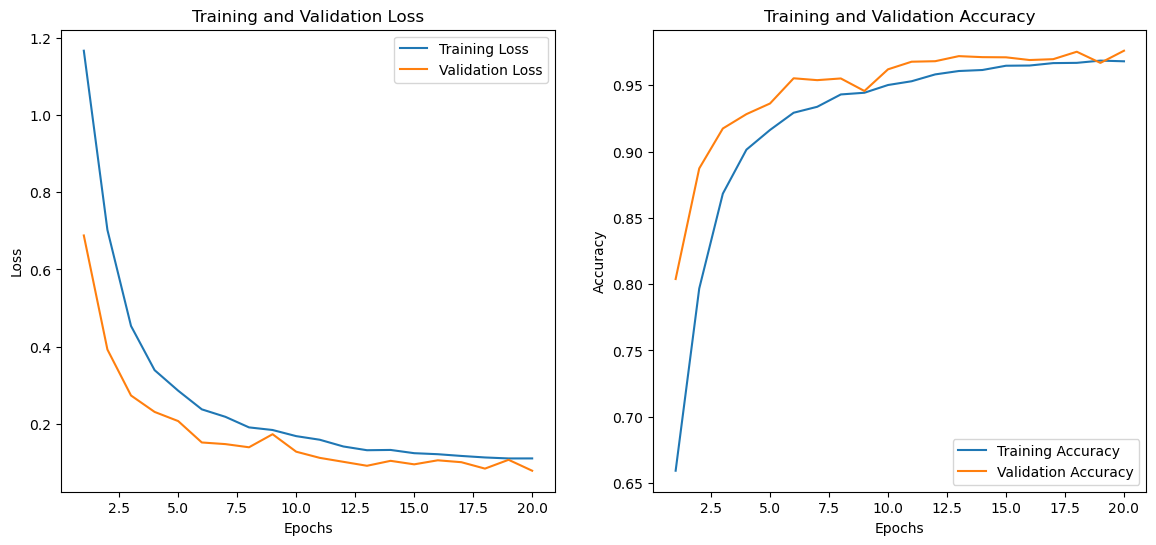

In [9]:
plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

In [10]:
torch.save(net, 'model.pth')

############################
- Adapted from Practical
############################

In [13]:
def evaluate(net, dataloader, device):
    net.eval() 
    all_targets = []
    all_predictions = []

    with torch.no_grad(): 
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1) 
            
            all_targets.extend(targets.cpu().numpy())  
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = np.mean(np.array(all_predictions) == np.array(all_targets))
    print(f'Accuracy: {accuracy:.4f}')

    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')

    return accuracy, precision, recall, f1


In [29]:
net = torch.load('model.pth')
accuracy, precision, recall, f1 = evaluate(net, test_loader, device)

Accuracy: 0.9789
Precision: 0.9791
Recall: 0.9789
F1-Score: 0.9784


############################
- Reference: https://www.kaggle.com/code/ahmedmedoeng/traffic-sign-recognition-with-cnn-98?scriptVersionId=195046147&cellId=19
############################

In [30]:
classes = { 
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)', 
    2: 'Speed limit (50km/h)', 
    3: 'Speed limit (60km/h)', 
    4: 'Speed limit (70km/h)', 
    5: 'Speed limit (80km/h)', 
    6: 'End of speed limit (80km/h)', 
    7: 'Speed limit (100km/h)', 
    8: 'Speed limit (120km/h)', 
    9: 'No passing', 
    10: 'No passing veh over 3.5 tons', 
    11: 'Right-of-way at intersection', 
    12: 'Priority road', 
    13: 'Yield', 
    14: 'Stop', 
    15: 'No vehicles', 
    16: 'Veh > 3.5 tons prohibited', 
    17: 'No entry', 
    18: 'General caution', 
    19: 'Dangerous curve left', 
    20: 'Dangerous curve right', 
    21: 'Double curve', 
    22: 'Bumpy road', 
    23: 'Slippery road', 
    24: 'Road narrows on the right', 
    25: 'Road work', 
    26: 'Traffic signals', 
    27: 'Pedestrians', 
    28: 'Children crossing', 
    29: 'Bicycles crossing', 
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing', 
    32: 'End speed + passing limits', 
    33: 'Turn right ahead', 
    34: 'Turn left ahead', 
    35: 'Ahead only', 
    36: 'Go straight or right', 
    37: 'Go straight or left', 
    38: 'Keep right', 
    39: 'Keep left', 
    40: 'Roundabout mandatory', 
    41: 'End of no passing', 
    42: 'End no passing veh > 3.5 tons' 
}

############################
- Coded by Webster Wang Wei Yang
############################

In [45]:
def predict_image(image_path, model):
    model.eval()
    
    device = next(model.parameters()).device
    
    image = Image.open(image_path).convert('RGB')

    predict_transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    ])
    
    img = predict_transform(image)
    
    img = img.to(device)
    
    xb = img.unsqueeze(0)
    
    with torch.no_grad():
        yb = model(xb)
        
    _, preds = torch.max(yb, dim=1)
    
    return preds.item()

############################
- Coded by Webster Wang Wei Yang
############################

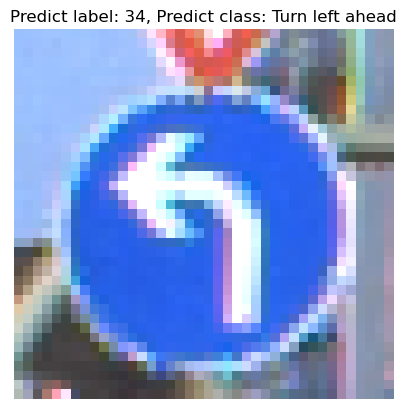

In [46]:
def display_image_with_prediction(image_path, model):
    pred_class_idx = predict_image(image_path, model)
    pred_class = classes[pred_class_idx]
        
    image = Image.open(image_path)
    plt.imshow(image)
    pred_class_idx
    plt.title(f"Predict label: {pred_class_idx}, Predict class: {pred_class}")
    plt.axis('off') 
    plt.show()

image_path = "GTSRB/Test/12493.png" 
display_image_with_prediction(image_path, net)  